<a href="https://colab.research.google.com/github/kooose38/pystan_practice/blob/main/%E7%8A%B6%E6%85%8B%E7%A9%BA%E9%96%93%E3%83%A2%E3%83%87%E3%83%AB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 状態空間モデル
時系列に従うデータであり、*t*は*t-1*に依存して線形性を持つモデルをサンプリング。

In [1]:
!unzip data.zip 

Archive:  data.zip
  inflating: data/data.xlsx          
  inflating: data/dose_response.xlsx  
  inflating: data/MAP_sample.xlsx    
  inflating: data/multilevel_modeling.xlsx  
  inflating: data/real_estate1.xlsx  
  inflating: data/real_estate2.xlsx  
  inflating: data/temperature_series.xlsx  
  inflating: data/~$wattage.xlsx     


In [2]:
!pip install -q pystan 

In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import pystan 
from scipy.stats import mstats
plt.style.use("ggplot")

In [4]:
filename = "/content/data/temperature_series.xlsx"
df = pd.read_excel(filename)
df.head()

,x,y
0,1891,-0.6291
1,1892,-0.7111
2,1893,-0.7520
3,1894,-0.7008
4,1895,-0.6752


(array([10., 12., 20., 23., 17., 13.,  9., 12.,  3.,  2.]),
 array([-0.8391 , -0.70949, -0.57988, -0.45027, -0.32066, -0.19105,
        -0.06144,  0.06817,  0.19778,  0.32739,  0.457  ]),
 <a list of 10 Patch objects>)

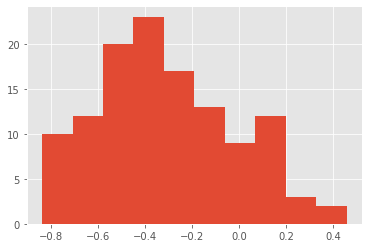

In [5]:
plt.hist(df["y"])

`y`は正規分布に従うと仮定する。

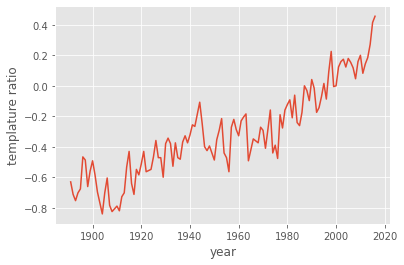

In [7]:
plt.plot(df["x"], df["y"])
plt.xlabel("year")
plt.ylabel("templature ratio")
plt.show()

* *t*時におけるパラメータ*mu*は*N(mu[t-1), sigma*に従う。
* *t*時における予測値*Y*は*N(mu[t], sigma)*に従う。

In [18]:
stan_model = """
data {
    int T;
    int T_new;
    real Y[T];
}

parameters {
    real mu[T];
    real<lower=0> s_mu;
    real<lower=0> s_Y;
}

model {
    for (t in 2:T) {
        mu[t] ~ normal(mu[t-1], s_mu);
    }

    for (t in 1:T) {
        Y[t] ~ normal(mu[t], s_Y);
    }
}

generated quantities {
    real mu_new;
    real Y_new[T+T_new];
    for (t in 1:T) {
        Y_new[t] = normal_rng(mu[t], s_Y);
    }
    mu_new = normal_rng(mu[T], s_mu);
    Y_new[T+T_new] = normal_rng(mu_new, s_Y);
}
"""

In [19]:
sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5a103ba5806007d160e318fb006e73b1 NOW.


In [20]:
stan_data = {"T": df.shape[0], "T_new": 1, "Y": df["y"]}

In [21]:
fit = sm.sampling(data=stan_data, iter=3000, warmup=1000, chains=3, seed=123)

In [22]:
fit


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_5a103ba5806007d160e318fb006e73b1.
3 chains, each with iter=3000; warmup=1000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=6000.

         mean se_mean     sd   2.5%    25%    50%    75%   97.5%  n_eff   Rhat
mu[1]   -0.66  6.8e-4   0.05  -0.77   -0.7  -0.66  -0.63   -0.56   6225    1.0
mu[2]   -0.69  7.1e-4   0.05  -0.78  -0.72  -0.69  -0.66    -0.6   4150    1.0
mu[3]    -0.7  1.2e-3   0.05   -0.8  -0.74  -0.71  -0.67   -0.61   1689    1.0
mu[4]   -0.68  8.4e-4   0.05  -0.77  -0.71  -0.68  -0.65   -0.59   3000    1.0
mu[5]   -0.64  6.0e-4   0.04  -0.72  -0.66  -0.64  -0.61   -0.55   5504    1.0
mu[6]   -0.55  1.6e-3   0.05  -0.65  -0.58  -0.55  -0.51   -0.45   1056    1.0
mu[7]   -0.55  1.2e-3   0.05  -0.64  -0.58  -0.54  -0.51   -0.45   1585    1.0
mu[8]   -0.59  8.1e-4   0.05  -0.68  -0.63  -0.59  -0.56    -0.5   3379    1.0
mu[9]   -0.57  7.1e-4   0.05  -0.66   -0.6  -0.57  -0.54   -

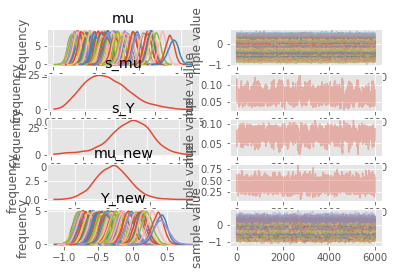

In [23]:
fig = fit.plot()

## 信頼区間推定

予測サンプリングされた`Y_new`を取り出して上下限をプロットする。

In [24]:
Y_new_arr = fit.extract("Y_new")["Y_new"]

In [25]:
Y_new_arr.shape

(6000, 122)

In [29]:
low_y50, high_y50 = mstats.mquantiles(Y_new_arr, [0.25, 0.75], axis=0)
low_y95, high_y95 = mstats.mquantiles(Y_new_arr, [0.025, 0.975], axis=0)

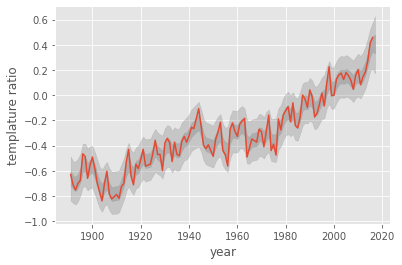

In [31]:
plt.plot(df["x"], df["y"])
x = df["x"].values 
x = np.append(x, 2017)
plt.fill_between(x, low_y50, high_y50, alpha=0.6, color="darkgray")
plt.fill_between(x, low_y95, high_y95, alpha=0.3, color="gray")
plt.xlabel("year")
plt.ylabel("templature ratio")
plt.show()